###  import data

In [5]:
import h5py
import numpy as np

data_path = "/Users/roseyu/Downloads/Data/neuro_data/"
file_name = "SharedData.mat"
arrays = {}

f= h5py.File(data_path+file_name, 'r')
for k, v in f.items():
    arrays[k] = np.array(v)
    
arrays.keys()

dict_keys(['#refs#', 'SessionDay', 'sdata', 'state', 'target', 'trialTimes'])

### data format
Session: S=14, Trial: T=56, Array: A=2 

SessionDay: Sx1      sdata:AxTxS   state:TxS   target: Sx1   trialTimes: Sx1

In [6]:
#prediction for one session and one trial
s_id = 0
y_ref =arrays['target'][s_id,0]
target_s = f[y_ref][()]
n_trial_s = len(target_s)

a_id = 0 #first electro-array
x_ref= arrays['sdata'][a_id,0:n_trial_s,s_id]

t_id = 0
ts_s = f[x_ref[t_id]]

sd_arrays = {}
for k, v in ts_s.items():
    sd_arrays[k] = np.array(v)
sd_arrays.keys()

dict_keys(['Channels', 'Electrodes', 'PacketIdx', 'RecordingBlock', 'Timestamps', 'Units', 'Waveforms'])

### Read, Encode Spikes

read electrodes data and use one hot encoding for the spikes

In [7]:
import sklearn 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# transform electro into binary feature
def encode(electrodes):
    enc =  OneHotEncoder()
    enc.fit(electrodes.transpose())
    one_hot_electro = enc.transform(electrodes.transpose()).toarray()
    return one_hot_electro

def read_sdata(a_id,t_id, s_id):
    """Args: 
           array id, trial id, session id
       Return:
           one hot encoding of electros
        """
    x_ref= arrays['sdata'][a_id,t_id,s_id]
    ts_s = f[x_ref]
    sd_arrays = {}
    for k, v in ts_s.items():
        sd_arrays[k] = np.array(v)
    #wave_forms = sd_arrays['Waveforms']
    #wave_ts = pd.DataFrame(wave_forms, index = time_stamps.squeeze())
    #wave_ts.join(electro)
    electro = encode(sd_arrays['Electrodes'])
    time_stamps = sd_arrays['Timestamps'].transpose()
#     electro_ts = pd.DataFrame((electro), index = time_stamps.squeeze())
    return np.concatenate((time_stamps, electro),axis=1)

### form tensor regression input/output

* use electrodes as features
* use targets as labels

In [14]:
# extract features
y_ref =arrays['target'][s_id,0]
target_s = f[y_ref][()]
n_trial_s = len(target_s)
y = target_s.squeeze()

n_sample = n_trial_s
spikes =[]
n_spike = np.zeros((n_trial_s))
for t_id in range(n_trial_s):
    x_i = read_sdata(a_id,t_id, s_id)
    spikes.append(x_i)
    n_spike[t_id] = len(x_i)

In [9]:
min_n_spike = np.min(n_spike).astype(int)
n_electro = 96

# simple truncation
# TBD: histcount with time interval

X = np.zeros((n_trial_s, min_n_spike, n_electro+1))
for t in range(n_trial_s):
    X[t,:,:] = spikes[t][:min_n_spike,:]

### fit a regression model

In [ ]:
# build predictive model
from tensorly.regression.kruskal_regression import KruskalRegressor
import tensorly.backend as T

X = T.tensor(X)
y = T.tensor(y)

rank = 2
estimator = KruskalRegressor(weight_rank=rank, tol=10e-7, n_iter_max=10, reg_W=1, verbose=0)
estimator.fit(X, y)

### latent factors 

In [44]:
res =estimator.kruskal_weight_
electro_latent = T.to_numpy(res[1])

<class 'numpy.ndarray'>


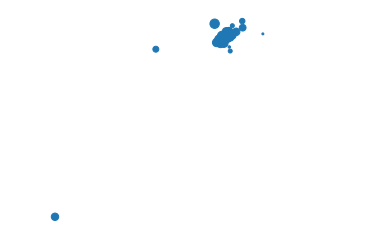

In [49]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1, 1,1)
ax.scatter(electro_latent[:,0],electro_latent[:,1], np.linspace(0,96),cmap=plt.cm.OrRd)
ax.set_axis_off()